In [1]:
import os
import pandas as pd
import numpy as np
import importlib
import time
import csv
import talib
import pandas_ta as ta
import random
from pathlib import Path
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
from pprint import pprint

import sqlite_io as sio
import add_indicators as indic
import split_merge as sm
import balance_light as balance

importlib.reload(sio)
importlib.reload(sm)
importlib.reload(indic)

<module 'add_indicators' from 'C:\\Projets\\MarketDataEnrichment\\dataset_mngr\\add_indicators.py'>

In [2]:
PATH_DATA = "C:\Projets\Data"
PATH_DB_FWK="C:\Projets\Data\sqlite\dataset_market.db"
PATH_FOREX="C:\Projets\Data\sqlite\dataset_forex.db"

In [3]:
if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

if "con_fx" in locals():
        sio.close_connection(con_fx)
con_fx = sio.get_connection(str_db_path=PATH_FOREX)


my_session_maker = sessionmaker(bind=con_fwk)
session=my_session_maker()

In [17]:
symb="EURUSD"
table_eurusd_m1="histdata_EURUSD_M1"
table_eurusd_h1="histdata_EURUSD_H1"
table_eurusd_d1="histdata_EURUSD_D1"
columns="OPEN_BAR,HIGH_BAR,LOW_BAR,CLOSE_BAR"

df_d1=sio.get_candles_to_df(session=session,con=con_fx, symbol_code=symb, only_close=False,target_table=table_eurusd_d1,columns_name=columns,skip_cond=True)
# rename colunms OPEN_BAR OPEN HIGH_BAR HIGH LOW_BAR LOW CLOSE_BAR CLOSE
df_d1.rename(columns={"OPEN_BAR":"OPEN","HIGH_BAR":"HIGH","LOW_BAR":"LOW","CLOSE_BAR":"CLOSE"},inplace=True)
df_d1.info() 

DEBUG: SELECT 'EURUSD' AS CODE,OPEN_DATETIME, OPEN_BAR,HIGH_BAR,LOW_BAR,CLOSE_BAR FROM histdata_EURUSD_D1 can
<class 'pandas.core.frame.DataFrame'>
Index: 3802 entries, 2010-01-04 00:00:00 to 2024-07-01 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODE    3802 non-null   object 
 1   OPEN    3802 non-null   float64
 2   HIGH    3802 non-null   float64
 3   LOW     3802 non-null   float64
 4   CLOSE   3802 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.2+ KB


In [11]:
df_d1.index = pd.to_datetime(df_d1.index)
# df_d1['bb_low']=ta.bbands(df_d1['CLOSE'],length=20).iloc[:,0]
# df_d1['bb_high']=ta.bbands(df_d1['CLOSE'],length=20).iloc[:,2]
blabla=ta.cdl_pattern(df_d1['OPEN'], df_d1['HIGH'],df_d1['LOW'], df_d1['CLOSE'],['hammer','invertedhammer','engulfing'])
# pprint(df_d1.tail(10))
print(blabla.describe())
pprint(blabla.tail(10))


        CDL_HAMMER  CDL_INVERTEDHAMMER  CDL_ENGULFING
count  3802.000000         3802.000000    3802.000000
mean      1.735928            1.025776       1.788532
std      13.062323           10.077305      32.794265
min       0.000000            0.000000    -100.000000
25%       0.000000            0.000000       0.000000
50%       0.000000            0.000000       0.000000
75%       0.000000            0.000000       0.000000
max     100.000000          100.000000     100.000000
               CDL_HAMMER  CDL_INVERTEDHAMMER  CDL_ENGULFING
OPEN_DATETIME                                               
2024-06-18            0.0                 0.0            0.0
2024-06-19            0.0                 0.0            0.0
2024-06-20            0.0                 0.0            0.0
2024-06-21            0.0                 0.0            0.0
2024-06-24            0.0                 0.0          100.0
2024-06-25            0.0                 0.0            0.0
2024-06-26            0.0 

In [18]:
dts_name="FOREX_1D_2D_V1"
df_d1.index = pd.to_datetime(df_d1.index)
df_d1_work = df_d1.copy()
# drop column sma20 if exist
# if "sma20" in df_d1_work.columns:
#     df_d1_work.drop(columns=["sma20"],inplace=True)
df_d1_work = indic.add_indicators_to_df(con=con_fwk, df_in=df_d1_work, dts_name=dts_name,symbol=symb)
df_d1_work.dropna(inplace=True)

In [19]:
pprint(df_d1_work[1000:1005])

                 CODE     OPEN     HIGH      LOW    CLOSE     sma20  \
OPEN_DATETIME                                                         
2013-10-16     EURUSD  1.35235  1.35667  1.34721  1.35332  1.353538   
2013-10-17     EURUSD  1.35337  1.36810  1.35150  1.36748  1.354272   
2013-10-18     EURUSD  1.36752  1.37032  1.36587  1.36856  1.355084   
2013-10-21     EURUSD  1.36832  1.36878  1.36504  1.36799  1.356022   
2013-10-22     EURUSD  1.36797  1.37912  1.36616  1.37802  1.357559   

               pos_sma20     sma50    sma200  pos_sma50  ...  lab_perf_10d  \
OPEN_DATETIME                                            ...                 
2013-10-16     -0.000161  1.339637  1.319673   0.010214  ...      0.014926   
2013-10-17      0.009753  1.340226  1.319875   0.020336  ...     -0.006728   
2013-10-18      0.009945  1.340914  1.320047   0.020618  ...     -0.014570   
2013-10-21      0.008825  1.341675  1.320196   0.019614  ...     -0.012178   
2013-10-22      0.015072  1.342712

In [48]:
# NNFX Rules
multiplier_SL=1.5
multiplier_TP=1.5
labels=[{'lab_perf_2d':2},{'lab_perf_5d':5},{'lab_perf_10d':10},{'lab_perf_20d':20}]
columns=[]
df_d1_work['SL_size']=df_d1_work['atr14']*multiplier_SL
df_d1_work['SL']=df_d1_work['CLOSE']-df_d1_work['SL_size']
df_d1_work['TP_size']=df_d1_work['atr14']*multiplier_TP
df_d1_work['TP']=df_d1_work['CLOSE']+df_d1_work['TP_size']
for label in labels:
    label_str=list(label.keys())[0]
    duration=label[label_str]
    
    df_d1_work[label_str + '_SLTP_hit'] = 0
    
    # Loop through each row in the DataFrame
    for i in range(len(df_d1_work)):
        
        # Check the next 'duration' days
        for j in range(1, duration + 1):
            if i + j < len(df_d1_work):
                if df_d1_work.at[df_d1_work.index[i + j], 'LOW'] <= df_d1_work.at[df_d1_work.index[i], 'SL']:
                    df_d1_work.at[df_d1_work.index[i], label_str + '_SLTP_hit'] = -1
                    break
                if df_d1_work.at[df_d1_work.index[i + j], 'HIGH'] >= df_d1_work.at[df_d1_work.index[i], 'TP']:
                    df_d1_work.at[df_d1_work.index[i], label_str + '_SLTP_hit'] = 1
                    break

    # df_d1_work[label_str+'_min']=df_d1_work['LOW'].shift(-duration).rolling(window=duration).min()
    # df_d1_work[label_str+'_max']=df_d1_work['HIGH'].shift(-duration).rolling(window=duration).max()

    df_d1_work[label_str+'_ratio']=(df_d1_work[label_str]/df_d1_work['SL_size']).round(2)
    # df_d1_work[label_str+'_ratio']=df_d1_work[label_str+'_ratio'].apply(lambda x: -1 if df_d1_work[label_str+'_min']<=df_d1_work['SL'] else x)
    # code this if df_d1_work[label_str+'_min']<=df_d1_work['SL']: df_d1_work[label_str+'_ratio']=-1
    # df_d1_work[label_str+'_ratio']=df_d1_work[label_str+'_ratio'].mask(df_d1_work[label_str+'_min']<=df_d1_work['SL'],-1)
    df_d1_work[label_str+'_ratio']=df_d1_work[label_str+'_ratio'].mask(df_d1_work[label_str+'_SLTP_hit']!=0,df_d1_work[label_str+'_SLTP_hit'])
    columns=columns+[label_str+'_ratio']




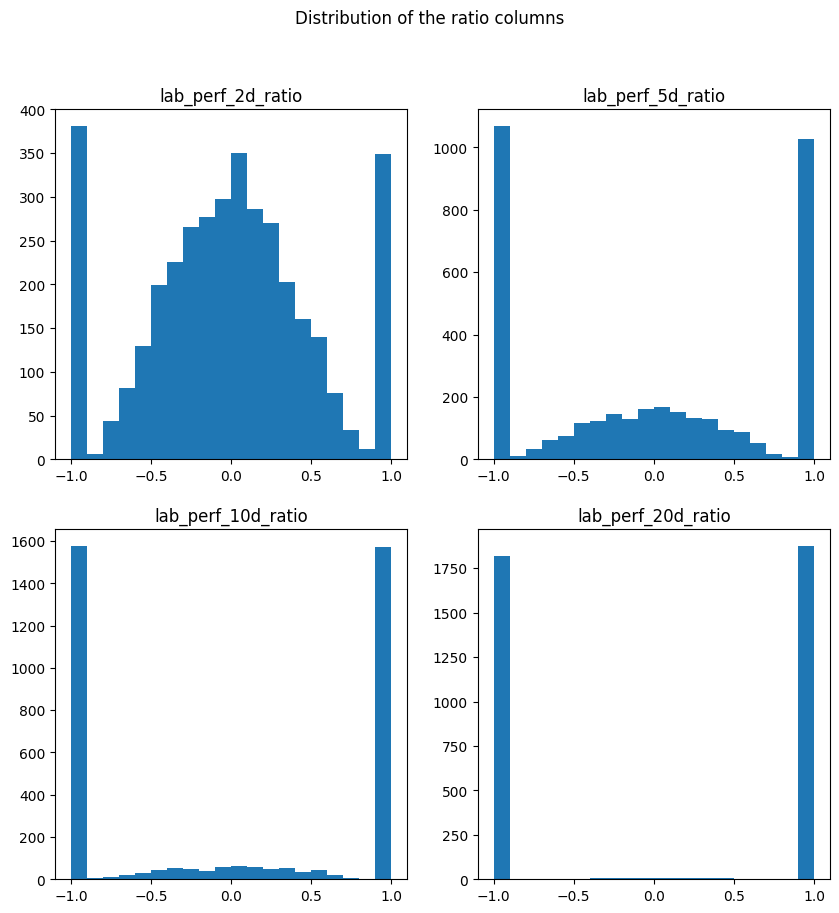

In [49]:
# print 4 graphs with the distribution of the ratio columns
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Distribution of the ratio columns')

for col, pos in zip(columns, positions):
    axs[pos].hist(df_d1_work[col], bins=20)
    axs[pos].set_title(col)

plt.show()

In [50]:
df_d1_work.to_csv(PATH_DATA+"\EURUSD_D1.csv")

In [4]:
# load from file
df_d1_work=pd.read_csv(PATH_DATA+"\EURUSD_D1.csv",index_col=0)
df_d1_work.index = pd.to_datetime(df_d1_work.index)
pprint(df_d1_work[1000:1005])


                 CODE     OPEN     HIGH      LOW    CLOSE     sma20  \
OPEN_DATETIME                                                         
2013-10-16     EURUSD  1.35235  1.35667  1.34721  1.35332  1.353538   
2013-10-17     EURUSD  1.35337  1.36810  1.35150  1.36748  1.354272   
2013-10-18     EURUSD  1.36752  1.37032  1.36587  1.36856  1.355084   
2013-10-21     EURUSD  1.36832  1.36878  1.36504  1.36799  1.356022   
2013-10-22     EURUSD  1.36797  1.37912  1.36616  1.37802  1.357559   

               pos_sma20     sma50    sma200  pos_sma50  ...  lab_perf_2d_min  \
OPEN_DATETIME                                            ...                    
2013-10-16     -0.000161  1.339637  1.319673   0.010214  ...          1.35150   
2013-10-17      0.009753  1.340226  1.319875   0.020336  ...          1.36504   
2013-10-18      0.009945  1.340914  1.320047   0.020618  ...          1.36504   
2013-10-21      0.008825  1.341675  1.320196   0.019614  ...          1.36616   
2013-10-22      

In [5]:
col_to_keep="pos_sma20,pos_sma50,pos_sma200,pos_sma50_200,pos_sma20_50,rsi14,sma5_rsi14,sma20_rsi14,pos_bb20_hi,pos_bb20_lo,ret_1d,ret_5d,pos_top20,pos_top50,pos_bot20,pos_bot50,aroon14_up,aroon14_down,aroon14_dif,macd_dif,pos_top_200,pos_bot_200,stdev20_1d,stdev20_sma5,pos_stdev20_sma5,stdev20_sma20,pos_stdev20_sma20,pos_rsi14_sma5,pos_rsi14_sma20,pos_rsi14_sma5_20,stoch14,stoch14_signal,stoch14_dif,adx14,adx14_neg,adx14_pos,adx14_dif,tr_atr14,pos_sma20_200,williamsr_14,perf_sma_50_5d,perf_sma_200_5d,pos_sma10,pos_sma5,perf_sma_20_5d,perf_sma_10_5d,hammer,engulfing,shootingstar,eveningstar,morningstar,3blackcrows,3whitesoldiers,inv_hammer,lab_perf_5d_ratio"
lab_class='lab_perf_5d_class'
columns=col_to_keep.split(",")
df_d1_work=df_d1_work[columns]
# if lab_perf_5d_ratio=-1 then 0 if lab_perf_5d_ratio>-1 and <=0 then 1 if lab_perf_5d_ratio>0 and <=1 then 2 if lab_perf_5d_ratio>1 then 3
df_d1_work.loc[:,lab_class]=df_d1_work['lab_perf_5d_ratio'].apply(lambda x: 0 if x==-1 else 1 if x>-1 and x<=0 else 2 if x>0 and x<1 else 3)

pprint(df_d1_work[1000:1005])


               pos_sma20  pos_sma50  pos_sma200  pos_sma50_200  pos_sma20_50  \
OPEN_DATETIME                                                                  
2013-10-16     -0.000161   0.010214    0.025496       0.015128      0.010377   
2013-10-17      0.009753   0.020336    0.036068       0.015419      0.010480   
2013-10-18      0.009945   0.020618    0.036751       0.015808      0.010568   
2013-10-21      0.008825   0.019614    0.036202       0.016269      0.010694   
2013-10-22      0.015072   0.026296    0.043611       0.016872      0.011057   

                   rsi14  sma5_rsi14  sma20_rsi14  pos_bb20_hi  pos_bb20_lo  \
OPEN_DATETIME                                                                 
2013-10-16     56.290591   57.317660    62.839742    -0.005088     0.004815   
2013-10-17     67.805510   59.610927    62.772360     0.003064     0.016531   
2013-10-18     68.487402   61.609946    62.767796     0.001880     0.018140   
2013-10-21     67.672729   63.095099    62.9

In [7]:
# count the number of each class
df_d1_work[lab_class].value_counts() #min class 2 at 820

lab_perf_5d_class
0    1069
3    1046
1     864
2     823
Name: count, dtype: int64

In [9]:
lab_reg='lab_perf_5d_ratio'
# df_d1_reg=df_d1_work.copy()
# df_d1_class=df_d1_work.copy()
df_d1_class=balance.class_custom_undersampler(df_in=df_d1_work,str_label=lab_class,nb_per_class=820)
df_d1_class.sort_index(inplace=True)

df_d1_reg=df_d1_class.copy()
df_d1_reg.drop(columns=lab_class,inplace=True)
df_d1_class.drop(columns=lab_reg,inplace=True)

list_feat = df_d1_class.columns.values.tolist()
list_feat.remove(lab_class)

df_d1_class[lab_class].value_counts()

lab_perf_5d_class
3    820
1    820
0    820
2    820
Name: count, dtype: int64

Correlation

In [ ]:
import seaborn as sns
corr_train = df_d1_class.corr()
fig, ax = plt.subplots(figsize=(12, 12))
corr_train.replace(1,0,inplace=True)
corr_train=corr_train.applymap(lambda x : None if x< 0.8 and x>-0.8 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)

corr_train_check=corr_train[corr_train >0.8]
corr_train_check.head()
sns.heatmap(corr_train_check, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)

Boruta to select features

In [24]:
df_d1_class.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3280 entries, 2010-01-04 to 2024-07-01
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pos_sma20          3266 non-null   float64
 1   pos_sma50          3238 non-null   float64
 2   pos_sma200         3109 non-null   float64
 3   pos_sma50_200      3109 non-null   float64
 4   pos_sma20_50       3238 non-null   float64
 5   rsi14              3270 non-null   float64
 6   sma5_rsi14         3267 non-null   float64
 7   sma20_rsi14        3254 non-null   float64
 8   pos_bb20_hi        3266 non-null   float64
 9   pos_bb20_lo        3266 non-null   float64
 10  ret_1d             3279 non-null   float64
 11  ret_5d             3276 non-null   float64
 12  pos_top20          3266 non-null   float64
 13  pos_top50          3238 non-null   float64
 14  pos_bot20          3266 non-null   float64
 15  pos_bot50          3238 non-null   float64
 16  aroon1

In [11]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
n_jobs=3

print(f"{df_d1_class.shape=}")
df_x_boruta, col_y_boruta = sm.split_df_x_y(
    df_in=df_d1_class, list_features=list_feat, str_label=lab_class, drop_na=True)
print(f"{df_x_boruta.shape=}")

rf_bo = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, max_depth=5)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1)
boruta_selector.fit(df_x_boruta.values, col_y_boruta.values)
# selected_features = df_x_boruta.columns[boruta_selector.support_]
# ranking_features = df_x_boruta.columns[boruta_selector.ranking_]
# print(ranking_features)
# print(f"{selected_features=}")

# not_selected_features = set(df_x_boruta.columns) - set(selected_features)
# print(f"{not_selected_features=}")

for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test: ", df_x_boruta.columns[i],
              " - Ranking: ", boruta_selector.ranking_[i], "✔️")
    else:
        print("Doesn't pass the test: ",
              df_x_boruta.columns[i], " - Ranking: ", boruta_selector.ranking_[i], "❌")
        

df_d1_class.shape=(3280, 55)
df_x_boruta.shape=(3106, 54)
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 

In [13]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
rnd_key=28
n_jobs=3

print(f"{df_d1_reg.shape=}")
df_x_boruta, col_y_boruta = sm.split_df_x_y(
    df_in=df_d1_reg, list_features=list_feat, str_label=lab_reg, drop_na=True)

rf_bo = RandomForestRegressor(n_estimators=100, n_jobs=n_jobs, max_depth=5)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key))
boruta_selector.fit(df_x_boruta.values, col_y_boruta.values)

for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test: ", df_x_boruta.columns[i],
              " - Ranking: ", boruta_selector.ranking_[i], "✔️")
    else:
        print("Doesn't pass the test: ",
              df_x_boruta.columns[i], " - Ranking: ", boruta_selector.ranking_[i], "❌")

df_d1_reg.shape=(3280, 55)
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
It

print graph candlestick

In [ ]:
# print graph with candlestick for 2024-05-01 to 2024-05-31 with pyplot
df_d1.index = pd.to_datetime(df_d1.index)
df_202405 = df_d1.loc['2024-05-01':'2024-05-31'].sort_index()
plt.figure() 
up = df_202405[df_202405.CLOSE_BAR >= df_202405.OPEN_BAR] 
down = df_202405[df_202405.CLOSE_BAR < df_202405.OPEN_BAR] 
col_red='red'
col_green='green'  
width_can=0.3
width_wicks=0.1
plt.bar(up.index, up.CLOSE_BAR-up.OPEN_BAR,width_can, bottom=up.OPEN_BAR, color=col_green)
plt.bar(up.index, up.HIGH_BAR-up.CLOSE_BAR,width_wicks, bottom=up.CLOSE_BAR, color=col_green)
plt.bar(up.index, up.LOW_BAR-up.OPEN_BAR,width_wicks, bottom=up.OPEN_BAR, color=col_green)

plt.bar(down.index, down.CLOSE_BAR-down.OPEN_BAR,width_can, bottom=down.OPEN_BAR, color=col_red)
plt.bar(down.index, down.HIGH_BAR-down.OPEN_BAR,width_wicks, bottom=down.OPEN_BAR, color=col_red)
plt.bar(down.index, down.LOW_BAR-down.CLOSE_BAR,width_wicks, bottom=down.CLOSE_BAR, color=col_red)

# Ensure the x-axis is treated as datetime
plt.gca().xaxis_date()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

